In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display

## Examples of all the functionality

### Load a maze env

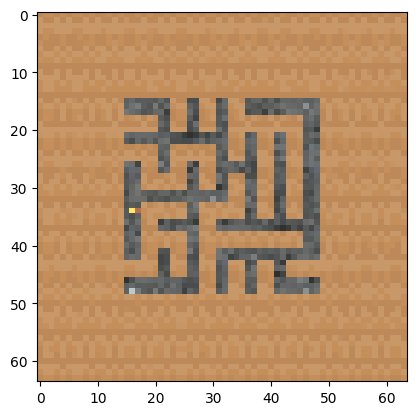

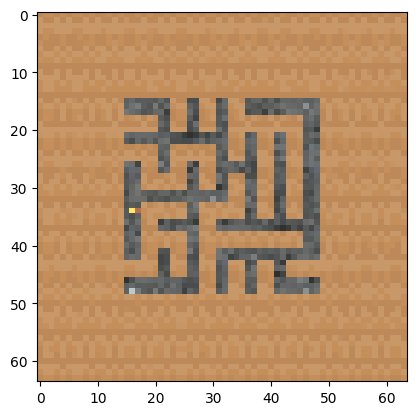

In [3]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
venv = ProcgenGym3Env(
    num=2, env_name='maze', num_levels=1, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)
obs = venv.reset()
# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    plt.imshow(obs[i].transpose(1, 2, 0))
    plt.show()

## Edit the maze interactively

Using the magic `maze.venv_editor` function!
Clicking in the maze changes walls to empty space and vise versa.
If you click the cheese it'll disappear and reappear where you click next.

**WARNING**: The `venv_editor` updates the `venv`, but after the mouse gets the cheese, the env will reset to its original state.

In [4]:
maze.venv_editor(venv)

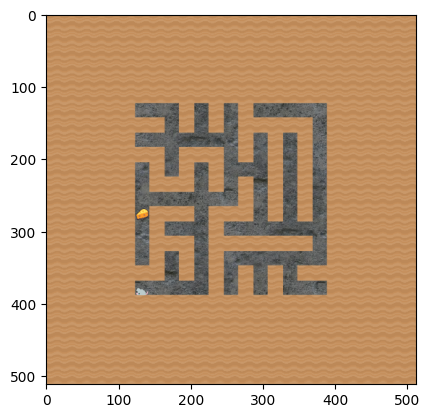

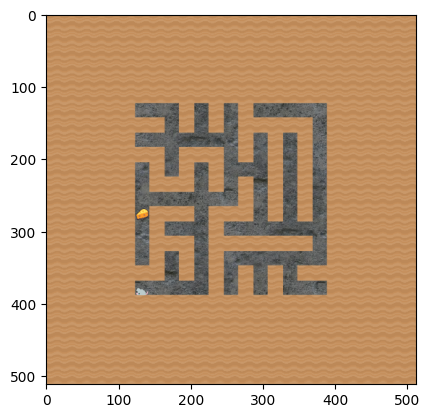

In [5]:
# Verify the venv got updated
info = venv.env.get_info()
for i in range(venv.num_envs):
    # plt.imshow(obs[i].transpose(1, 2, 0))
    plt.imshow(info[i]['rgb'])
    plt.show()

## Run the model on the new maze

In [6]:
if COLAB:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [7]:
# download from https://drive.google.com/file/d/1db1qJn_ZM49CUcA1k7uSMdsdiAQ4eR5a/view?usp=share_link
policy = load_policy('./models/model_rand_region_5.pth', action_size=venv.action_space.n, device=torch.device('cpu'))

KeyboardInterrupt: 

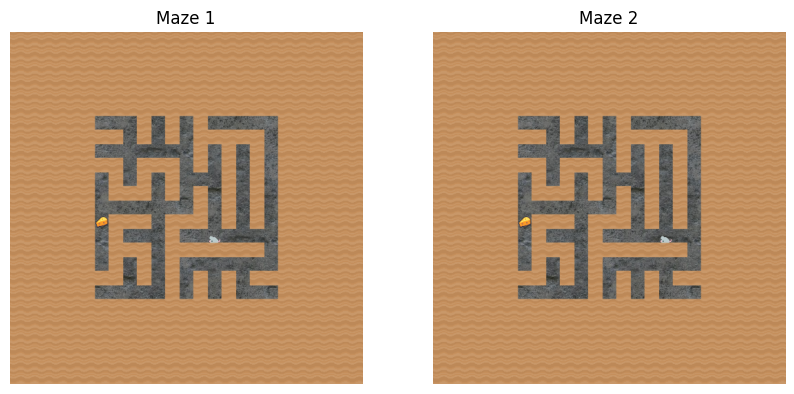

In [8]:
done = np.zeros(venv.num_envs)
obs = venv.reset()

fig, ax = plt.subplots(1, venv.num_envs, figsize=(10, 8))

while not all(done):
    policy.eval()
    p, v = policy(torch.FloatTensor(obs))
    act = p.sample().numpy()
    #act = p.probs.argmax(dim=-1).numpy()
    obs, rew, done_now, info = venv.step(act)
    done = np.logical_or(done, done_now) # TODO: Don't keep running finished envs 

    if not all(done): # don't show last frame (new maze)
        # plt.imshow(obs[0].transpose(1,2,0)) # agent view
        for i in range(len(ax)):
            ax[i].set_title(f'Maze {i+1}')
            ax[i].imshow(info[i]['rgb'])
            ax[i].axis('off')
        
        display.display(fig)
        display.clear_output(wait=True)


### Under the hood: Less magic venv manipulation

The `maze.EnvState` class wraps the `state_bytes` from a specific maze env. It has an array of helpers for manipulating mazes.

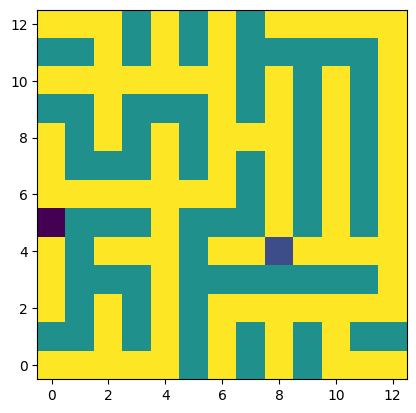

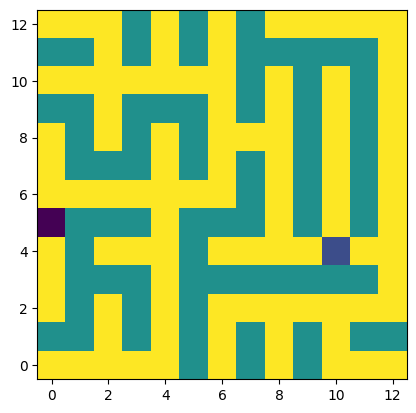

In [9]:
env_states = [maze.EnvState(sb) for sb in venv.env.callmethod("get_state")]
for es in env_states:
    plt.imshow(es.inner_grid(), origin='lower')
    plt.show()

#### Move the mouse to the top right

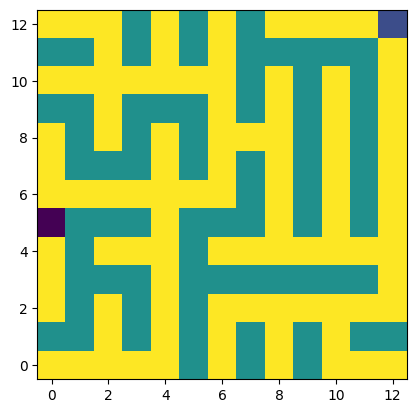

In [11]:
g = env_states[0].inner_grid()
x,y = maze.get_mouse_pos(g) # a trivial numpy helper
g[x, y] = maze.EMPTY
g[12,12] = maze.MOUSE
plt.imshow(g, origin='lower')

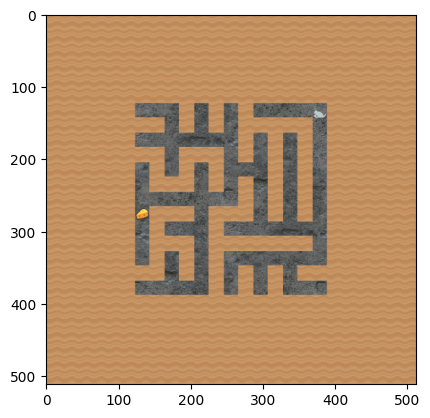

In [15]:
# Looks good! now to update the maze itself
env_states[0].set_grid(g, pad=True) # Update the EnvState. Pad=True to add walls around the maze
venv.env.callmethod("set_state", [s.state_bytes for s in env_states]) # Update the venv
plt.imshow(venv.env.get_info()[0]['rgb'])